<a href="https://colab.research.google.com/github/MauriBrainiac/Proyecto-/blob/main/Codigo%20%20-%20An%C3%A1lisis%20cinem%C3%A1tico%20de%20los%20ciclos%20de%20conducci%C3%B3n%20Takeoff%20Cycles/An%C3%A1lisis%20cinem%C3%A1tico%20de%20los%20ciclos%20de%20conducci%C3%B3n%20Takeoff%20Cycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DISEÑO DEL SISTEMA DE RODAJE ELÉCTRICO (EGTS) CON INTELIGENCIA ARTIFICIAL Y MACHINE LEARNING PARA AHORRO DE COMBUSTIBLE EN LAS AERONAVES COMERCIALES BOEING 737 NG.**

**Herramienta Google Colaboratory.**

**Entorno de desarrollo en Python y Google Colaboratory.**

• Python 3.10 – Anaconda Navigator.Ink.

• Tensorflow 2.14.0.

• Keras 2.14.0.

• Scikit-learn (sklearn) 1.3.2.

• Numpy 1.26.2.

• Pandas 2.1.3.

**Importación de las bibliotecas requeridas**

In [ ]:
# importando las bibliotecas requeridas.
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers import Activation, Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from tqdm import tqdm
np.random.seed(1234)
PYTHONHASHSEED = 0

**Elección del conjunto de datos (dataset).**

• Análisis de los ciclos de conducción Takeoff Cycles.

**Conexión de las rutas del conjunto de datos analisis cinemático de los ciclos de conducción Takeoff Cycles en formato csv**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Ruta del archivo en formato csv.
archivo_csv = "/content/drive/MyDrive/Sistema de rodaje eléctrico (EGTS) /Análisis cinemático de los ciclos de conducción Takeoff Cycles.csv"
# Cargando el archivo en formato csv del un conjunto de datos (dataset).
data = pd.read_csv(archivo_csv)
data.to_csv("/content/drive/MyDrive/Sistema de rodaje eléctrico (EGTS) /Análisis cinemático de los ciclos de conducción Takeoff Cycles.csv", index=False)

In [ ]:
# Eliminando las columnas 5 y 9.
data = data.drop(columns=[data.columns[5], data.columns[6], data.columns[7], data.columns[8], data.columns[9]])

In [ ]:
import pandas as pd
# Reemplazando las comas por puntos en columnas numéricas del archivo en formato csv.
numeric_columns = data.columns[1:]  # Seleccionando todas las columnas numéricas.

def replace_commas_with_points(x):
    try:
        return float(x.replace(',', '.'))
    except (ValueError, AttributeError):
        return x

data[numeric_columns] = data[numeric_columns].applymap(replace_commas_with_points)

In [ ]:
data.head(20000) # Muestra la cantidad del conjunto de datos (dataset) archivo en formato csv.

,Takeoff Cycles,Max. Acceleration amax[m/s²],Max. Velocity vmax [km/h],Max. Traction Force FTM [kN] net,Max. Traction Power PTM [kW] net
0,London 1,0.750,48.102,68.40,268.96
1,London 1,0.750,48.102,68.40,268.96
2,London 1,0.750,48.102,68.40,268.96
3,London 1,0.750,48.102,68.40,268.96
4,London 1,0.750,48.102,68.40,268.96
...,...,...,...,...,...
19994,Berlin 4,0.389,33.300,35.47,128.84
19995,Berlin 4,0.389,33.300,35.47,128.84
19996,Berlin 4,0.389,33.300,35.47,128.84
19997,Berlin 4,0.389,33.300,35.47,128.84


**Tratamiento de valores atípicos de las variables cinemáticas: Aceleración Máxima (amax), Velocidad Máxima (vmax), Fuerza de Tracción Máxima (FTM) y Potencia de Tracción Máxima (PTM) en Takeoff Cycles**

In [ ]:
# Verificando si hay valores faltantes en el conjunto de datos (dataset).
missing_values = data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

# Tratamiento de los valores atípicos (utilizando z-scores).
z_scores = (data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std()
outliers = (z_scores.abs() > 3).any(axis=1)
print("Número de filas con valores atípicos:", outliers.sum())

Valores faltantes por columna:
Takeoff Cycles                      0
Max. Acceleration amax[m/s²]        0
Max. Velocity vmax [km/h]           0
Max. Traction Force FTM [kN] net    0
Max. Traction Power PTM [kW] net    0
dtype: int64
Número de filas con valores atípicos: 0


In [ ]:
columnas_orden = ['Takeoff Cycles',
                  'Max. Acceleration amax[m/s²]',
                  'Max. Velocity vmax [km/h]',
                  'Max. Traction Force FTM [kN] net',
                  'Max. Traction Power PTM [kW] net']
data_ordenado = data.sort_values(by=columnas_orden, ascending=[False, False, False, False, False])

**Valores máximos de las variables cinemáticas: Aceleración Máxima (amax), Velocidad Máxima (vmax), Fuerza de Tracción Máxima (FTM) y Potencia de Tracción Máxima (PTM) en Takeoff Cycles**

In [ ]:
import pandas as pd

# Valores de la variable  Max. Acceleration 𝑎𝑚𝑎𝑥[m/s²].
values = ['0.92', '0.471', '0.862', '0.445', '0.5', '0.777', '0.805', '0.42', '0.75', '1.14',
 '1.03', '0.83', '0.95', '0.389', '0.39', '0.306']

num_rows = len(values)

columns_to_check = ['Takeoff Cycles', 'Max. Acceleration amax[m/s²]',
                    'Max. Velocity vmax [km/h]', 'Max. Traction Force FTM [kN] net',
                    'Max. Traction Power PTM [kW] net']

data_ordenado = pd.DataFrame({
    'Takeoff Cycles': ['Washington 1', 'Toronto 6', 'Toronto 5', 'Toronto 4', 'Toronto 3',
                        'Toronto 2b', 'Toronto 1', 'Munich 1', 'London 2', 'London 1', 'Hamilton',
                        'Frankfurt 1', 'Dallas 2a', 'Dallas 1', 'Calgary 1', 'Berlin 4', 'Berlin 3',
                        'Berlin 2', 'Berlin 1'] [:num_rows],
    'Max. Acceleration amax[m/s²]': values,
    'Max. Velocity vmax [km/h]': ['35.2', '19.2', '24.1', '32.3', '28.7', '48.5', '27.5', '46.2', '48.2', '48.102',
                     '53.602', '48.4', '61.8', '38.2', '45.1', '33.3', '44.9', '41.102', '30.703'] [:num_rows],
    'Max. Traction Force FTM [kN] net': ['83.62', '43', '78.67', '40.62', '45.77', '70.94', '73.5','38',
                     '38.05', '68.4', '104', '93.73', '38.1', '76.01', '86.4','35.47', '27.94','40.6'] [:num_rows],
    'Max. Traction Power PTM [kW] net': ['204.3', '126.98', '308.15', '196.31', '165.29', '361.2', '325.7',
                     '382.33', '190.23', '268.96', '494.2', '584.77', '227.22','336', '286.1', '128.84','181.14','159.04','260.7'] [:num_rows]
})

# Calculando y mostrando los valores numericos maximos de cada una de las variables del conjunto de datos (dataset).
for column in columns_to_check:
    if column != 'Takeoff Cycles':
        max_value = data_ordenado[column].str.replace(',', '').astype(float).max()
        print(f"Número máximo en '{column}': {max_value}")
    else:
        print(f"Nombres en 'Takeoff Cycles':")
        print(data_ordenado[column])

Nombres en 'Takeoff Cycles':
0     Washington 1
1        Toronto 6
2        Toronto 5
3        Toronto 4
4        Toronto 3
5       Toronto 2b
6        Toronto 1
7         Munich 1
8         London 2
9         London 1
10        Hamilton
11     Frankfurt 1
12       Dallas 2a
13        Dallas 1
14       Calgary 1
15        Berlin 4
Name: Takeoff Cycles, dtype: object
Número máximo en 'Max. Acceleration amax[m/s²]': 1.14
Número máximo en 'Max. Velocity vmax [km/h]': 61.8
Número máximo en 'Max. Traction Force FTM [kN] net': 104.0
Número máximo en 'Max. Traction Power PTM [kW] net': 584.77


**Verificación del tipo de valores numéricos de las variables cinemáticas: Aceleración Máxima (amax), Velocidad Máxima (vmax), Fuerza de Tracción Máxima (FTM) y Potencia de Tracción Máxima (PTM) en Takeoff Cycles**

In [ ]:
# Verificando y imprimiendo el tipo de las columnas del conjunto de datos (dataset).
print(data.dtypes)

Takeoff Cycles                       object
Max. Acceleration amax[m/s²]        float64
Max. Velocity vmax [km/h]           float64
Max. Traction Force FTM [kN] net    float64
Max. Traction Power PTM [kW] net    float64
dtype: object


**Diseño y Evaluación con redes neuronales RNN bidireccional con Dropout del 20% y función de activación SoftMax para las variables cinemáticas: Aceleración Máxima (amax), Velocidad Máxima (vmax), Fuerza de Tracción Máxima (FTM) y Potencia de Tracción Máxima (PTM) en Takeoff Cycles.**

Epoch 1/15
119/119 - 7s - loss: 2.3862 - accuracy: 0.2161 - val_loss: 1.7771 - val_accuracy: 0.3063 - 7s/epoch - 61ms/step
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 - 1s - loss: 1.2308 - accuracy: 0.5251 - val_loss: 0.7432 - val_accuracy: 0.8363 - 1s/epoch - 9ms/step
Epoch 3/15
119/119 - 1s - loss: 0.6388 - accuracy: 0.7784 - val_loss: 0.4664 - val_accuracy: 0.8313 - 1s/epoch - 9ms/step
Epoch 4/15
119/119 - 1s - loss: 0.4495 - accuracy: 0.8469 - val_loss: 0.3480 - val_accuracy: 0.8838 - 1s/epoch - 9ms/step
Epoch 5/15
119/119 - 1s - loss: 0.3557 - accuracy: 0.8763 - val_loss: 0.2880 - val_accuracy: 0.8888 - 1s/epoch - 9ms/step
Epoch 6/15
119/119 - 1s - loss: 0.2968 - accuracy: 0.8946 - val_loss: 0.2392 - val_accuracy: 0.9413 - 1s/epoch - 9ms/step
Epoch 7/15
119/119 - 1s - loss: 0.2465 - accuracy: 0.9186 - val_loss: 0.1998 - val_accuracy: 0.9438 - 1s/epoch - 9ms/step
Epoch 8/15
119/119 - 1s - loss: 0.2125 - accuracy: 0.9310 - val_loss: 0.1709 - val_accuracy: 0.9388 - 1s/epoch - 9ms/step
Epoch 9/15
119/119 - 2s - loss: 0.1850 - accuracy: 0.9431 - val_loss: 0.1479 - val_accuracy: 0.9438 - 2s/epoch - 15ms/step
Epoch 10/15
119/119 - 2s - loss: 0

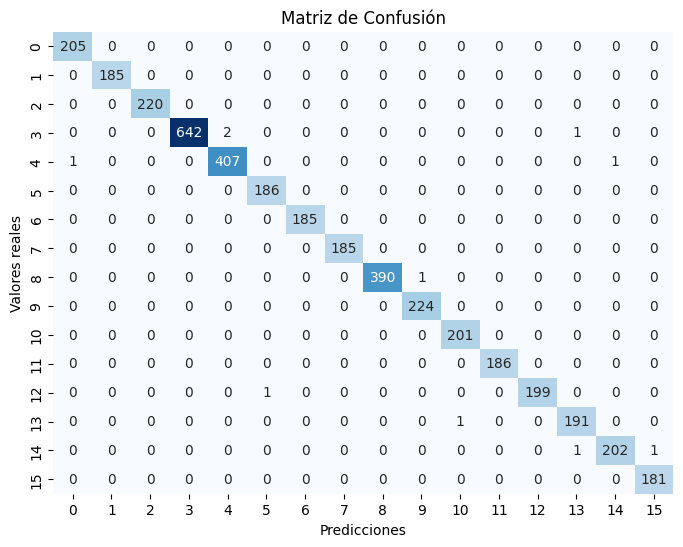

Informe de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00       185
           2       1.00      1.00      1.00       220
           3       1.00      1.00      1.00       645
           4       1.00      1.00      1.00       409
           5       0.99      1.00      1.00       186
           6       1.00      1.00      1.00       185
           7       1.00      1.00      1.00       185
           8       1.00      1.00      1.00       391
           9       1.00      1.00      1.00       224
          10       1.00      1.00      1.00       201
          11       1.00      1.00      1.00       186
          12       1.00      0.99      1.00       200
          13       0.99      0.99      0.99       192
          14       1.00      0.99      0.99       204
          15       0.99      1.00      1.00       181

    accuracy                           1.00      3999

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Dropout, LSTM
import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionando las columnas del conjunto de datos (dataset).
data = data[['Takeoff Cycles', 'Max. Acceleration amax[m/s²]', 'Max. Velocity vmax [km/h]',
             'Max. Traction Force FTM [kN] net', 'Max. Traction Power PTM [kW] net']]

# Escalando el conjunto de datos (dataset).
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.iloc[:, 1:])

# Obteniendo las etiquetas de 'Takeoff Cycles' sin escalar.
takeoff_cycles = data['Takeoff Cycles']

# Definiendo la ventana de tiempo como entrada.
window_size = 5
X, y = [], []

for i in range(window_size, len(data_scaled)):
    X.append(data_scaled[i - window_size:i, 3:])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Dividiendo el conjunto de datos (dataset) en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Codificacion de las etiquetas.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Creando el modelo de las redes RNN (Recurrent Neural Networks) bidireccional asignando un número de unidades en su capa de salida para la clasificación de activacion softmax.
modelo = Sequential()
modelo.add(Bidirectional(LSTM(
    units=50,  # Número de unidades en la capa.
    return_sequences=False
), input_shape=(window_size, X_train.shape[2])))

# Capa de Dropout del 20%.
modelo.add(Dropout(0.2))

# Capa densa de salida para la clasificación de activacion softmax.
modelo.add(Dense(units=len(np.unique(y_train_encoded)), activation='softmax'))

# Compilando el modelo de las redes RNN (Recurrent Neural Networks) bidireccional.
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Ajusta la tasa de aprendizaje según sea necesario.
modelo.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Definiendo la ruta para guardar el modelo de las redes RNN (Recurrent Neural Networks) bidireccional.
RNN_fwd_path = 'mejor_modelo.h5'

# Definiendo los hiperparámetros.
epochs = 15
batch_size = 128

# Entrenamiento del modelo de las redes RNN (Recurrent Neural Networks) bidireccional.
RNN_fwd_history = modelo.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(RNN_fwd_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# Guarda el modelo en el formato nativo de Keras (.h5).
modelo.save('mejor_modelo.h5')

# Evaluando el modelo en el conjunto de prueba.
score = modelo.evaluate(X_test, y_test_encoded)
print(f"Pérdida en el conjunto de prueba: {score[0]}")
print(f"Precisión en el conjunto de prueba: {score[1]}")

# Obteniendo las predicciones.
def custom_predict(model, X):
    return model.predict(X)
y_pred = custom_predict(modelo, X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Creación de la matriz de confusión.
confusion = confusion_matrix(y_test_encoded, y_pred_classes)

# Muestra de la matriz de confusión.
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de Confusión')
plt.show()

# Imprimiendo el informe de clasificación.
classification_rep = classification_report(y_test_encoded, y_pred_classes, zero_division=1)
print("Informe de Clasificación:\n", classification_rep)

# Imprimiendo el resumen del modelo de las redes RNN (Recurrent Neural Networks) bidireccional.
modelo.summary()
print("RNN (Recurrent Neural Networks) bidireccional")

Epoch 1/15
125/125 [==============================] - 9s 27ms/step - loss: 0.8970 - accuracy: 0.0493 - val_loss: 0.1806 - val_accuracy: 0.0513
Epoch 2/15
125/125 [==============================] - 3s 26ms/step - loss: 0.1534 - accuracy: 0.0500 - val_loss: 0.0997 - val_accuracy: 0.0513
Epoch 3/15
125/125 [==============================] - 3s 22ms/step - loss: 0.1004 - accuracy: 0.0596 - val_loss: 0.0789 - val_accuracy: 0.0513
Epoch 4/15
125/125 [==============================] - 1s 11ms/step - loss: 0.0832 - accuracy: 0.0721 - val_loss: 0.0650 - val_accuracy: 0.0513
Epoch 5/15
125/125 [==============================] - 1s 11ms/step - loss: 0.0658 - accuracy: 0.0821 - val_loss: 0.0440 - val_accuracy: 0.0965
Epoch 6/15
125/125 [==============================] - 1s 11ms/step - loss: 0.0453 - accuracy: 0.0930 - val_loss: 0.0275 - val_accuracy: 0.0965
Epoch 7/15
125/125 [==============================] - 2s 15ms/step - loss: 0.0318 - accuracy: 0.0970 - val_loss: 0.0157 - val_accuracy: 0.0965

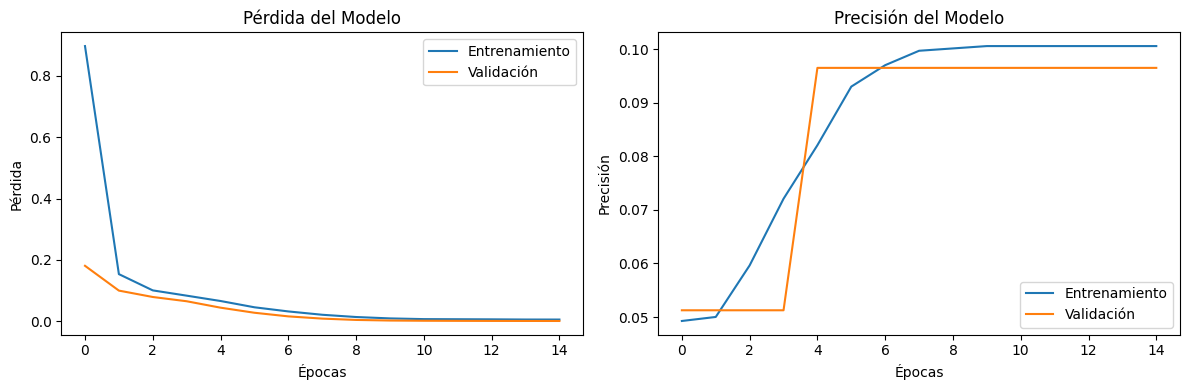

In [ ]:
# Creando el modelo de las redes RNN (Recurrent Neural Networks) bidireccional asignando un número de unidades en su capa de salida para la clasificación de activacion softmax.
modelo = Sequential()
modelo.add(Bidirectional(LSTM(
    units=50,  # Número de unidades en la capa.
    return_sequences=False
), input_shape=(window_size, X_train.shape[2])))

# Capa de Dropout del 20%.
modelo.add(Dropout(0.2))

# Capa densa de salida para la clasificación de activacion softmax.
modelo.add(Dense(units=len(np.unique(y_train_encoded)), activation='softmax'))

# Compilando el modelo de las redes RNN (Recurrent Neural Networks) bidireccional.
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Ajusta la tasa de aprendizaje según sea necesario.
modelo.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entrenamiento del modelo y guardar el historial del entrenamiento.
history = modelo.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

# Extraendo las métricas del entrenamiento y validación.
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']  #'val_accuracy' esta en el historial.

# Creando gráficos.
plt.figure(figsize=(12, 4))

# Gráfico de pérdida mostrando el cambio de pérdida durante su entrenamiento y validación.
plt.subplot(1, 2, 1)
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de precisión mostrando el cambio de la precisión durante su entrenamiento y validación.
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

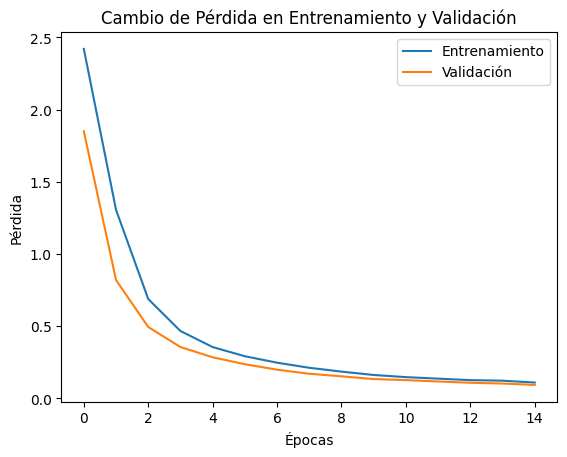

In [ ]:
import matplotlib.pyplot as plt

# Extraendo las métricas de entrenamiento y validación del historial.
train_loss = RNN_fwd_history.history['loss']
val_loss = RNN_fwd_history.history['val_loss']

# Creando un gráfico para mostrar el cambio de pérdida en los conjuntos de entrenamiento y validación.
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Cambio de Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

**Diseño y Evaluación con redes neuronales LSTM con Dropout del 20% y función de activación Sigmoid para las variables cinemáticas: Aceleración Máxima (amax), Velocidad Máxima (vmax), Fuerza de Tracción Máxima (FTM) y Potencia de Tracción Máxima (PTM) en Takeoff Cycles.**

Epoch 1/10
238/238 - 5s - loss: 1.6870 - accuracy: 0.4098 - val_loss: 0.6721 - val_accuracy: 0.7862 - 5s/epoch - 19ms/step
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 - 2s - loss: 0.5262 - accuracy: 0.8329 - val_loss: 0.3208 - val_accuracy: 0.8888 - 2s/epoch - 8ms/step
Epoch 3/10
238/238 - 4s - loss: 0.3102 - accuracy: 0.9105 - val_loss: 0.2163 - val_accuracy: 0.9962 - 4s/epoch - 15ms/step
Epoch 4/10
238/238 - 2s - loss: 0.2268 - accuracy: 0.9408 - val_loss: 0.1654 - val_accuracy: 0.9438 - 2s/epoch - 8ms/step
Epoch 5/10
238/238 - 2s - loss: 0.1844 - accuracy: 0.9591 - val_loss: 0.1430 - val_accuracy: 0.9438 - 2s/epoch - 9ms/step
Epoch 6/10
238/238 - 2s - loss: 0.2143 - accuracy: 0.9464 - val_loss: 0.1152 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 7/10
238/238 - 2s - loss: 0.1376 - accuracy: 0.9766 - val_loss: 0.1093 - val_accuracy: 0.9388 - 2s/epoch - 8ms/step
Epoch 8/10
238/238 - 2s - loss: 0.1329 - accuracy: 0.9708 - val_loss: 0.0911 - val_accuracy: 0.9962 - 2s/epoch - 9ms/step
Epoch 9/10
238/238 - 4s - loss: 0.1146 - accuracy: 0.9814 - val_loss: 0.2365 - val_accuracy: 0.9388 - 4s/epoch - 15ms/step
Epoch 10/10
238/238 - 2s - loss: 

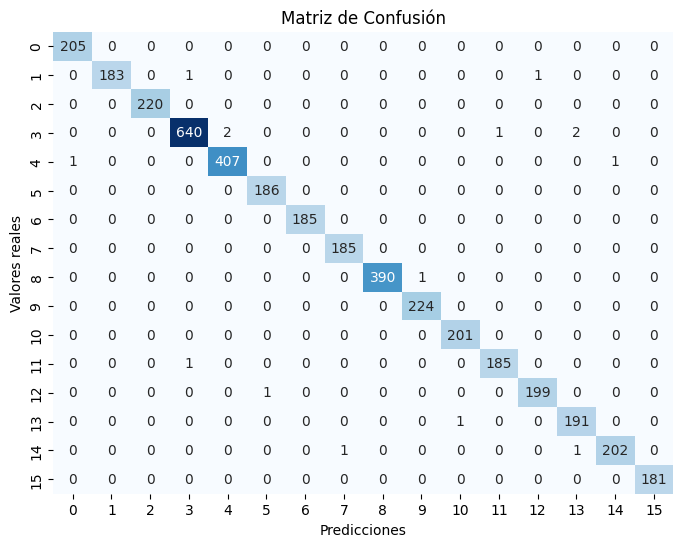

Informe de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      0.99      0.99       185
           2       1.00      1.00      1.00       220
           3       1.00      0.99      0.99       645
           4       1.00      1.00      1.00       409
           5       0.99      1.00      1.00       186
           6       1.00      1.00      1.00       185
           7       0.99      1.00      1.00       185
           8       1.00      1.00      1.00       391
           9       1.00      1.00      1.00       224
          10       1.00      1.00      1.00       201
          11       0.99      0.99      0.99       186
          12       0.99      0.99      0.99       200
          13       0.98      0.99      0.99       192
          14       1.00      0.99      0.99       204
          15       1.00      1.00      1.00       181

    accuracy                           1.00      3999

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical

# Seleccionando las columnas del conjunto de datos (dataset).
data = data[['Takeoff Cycles', 'Max. Acceleration amax[m/s²]', 'Max. Velocity vmax [km/h]',
             'Max. Traction Force FTM [kN] net', 'Max. Traction Power PTM [kW] net']]

# Escalando el conjunto de datos (dataset).
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.iloc[:, 1:])

# Obteniendo las etiquetas de 'Takeoff Cycles' sin escalar.
takeoff_cycles = data['Takeoff Cycles']

# Definiendo la ventana de tiempo como entrada.
window_size = 5
X, y = [], []

for i in range(window_size, len(data_scaled)):
    X.append(data_scaled[i - window_size:i, 3:])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Dividiendo el conjunto de datos (dataset) en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Codificacion de las etiquetas.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Creando el modelo de las redes LSTM (Long Short-Term Memory) en su capa de salida con activación Sigmoide.
modelo = Sequential()
modelo.add(LSTM(units=100, return_sequences=False, input_shape=(window_size, X_train.shape[2])))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=len(np.unique(y_train_encoded)), activation='sigmoid'))

# Compilando el modelo de las redes LSTM (Long Short-Term Memory) con la métrica 'accuracy'.
modelo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definiendo la ruta para guardar el modelo de las redes LSTM (Long Short-Term Memory).
LSTM_model_path = 'mejor_modelo_lstm.h5'

# Definiendo los hiperparámetros
epochs = 10
batch_size = 64

#Entrenamiento del modelo de las redes LSTM (Long Short-Term Memory) y guardando el historial del entrenamiento.
LSTM_history = modelo.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(LSTM_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
# Guardando el modelo en el formato nativo de Keras (.h5).
modelo.save('mejor_modelo.h5')

# Evaluando el modelo en el conjunto de prueba.
score = modelo.evaluate(X_test, y_test_encoded)
print(f"Pérdida en el conjunto de prueba: {score[0]}")
print(f"Precisión en el conjunto de prueba: {score[1]}")

# Obteniendo las predicciones.
def custom_predict(model, X):
    return model.predict(X)
y_pred = custom_predict(modelo, X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Creación de la matriz de confusión.
confusion = confusion_matrix(y_test_encoded, y_pred_classes)

# Muestra de la matriz de confusión.
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de Confusión')
plt.show()

# Imprimiendo el informe de clasificación.
classification_rep = classification_report(y_test_encoded, y_pred_classes, zero_division=1)
print("Informe de Clasificación:\n", classification_rep)

# Imprimiendo el resumen del modelo de las redes LSTM (Long Short-Term Memory).
modelo.summary()
print("LSTM (Long Short-Term Memory)")

Epoch 1/10
238/238 - 8s - loss: 1.7226 - accuracy: 0.3926 - val_loss: 0.7037 - val_accuracy: 0.8963 - 8s/epoch - 32ms/step
Epoch 2/10
238/238 - 2s - loss: 0.5327 - accuracy: 0.8366 - val_loss: 0.3229 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 3/10
238/238 - 2s - loss: 0.3086 - accuracy: 0.9156 - val_loss: 0.2116 - val_accuracy: 0.9438 - 2s/epoch - 8ms/step
Epoch 4/10
238/238 - 2s - loss: 0.2200 - accuracy: 0.9431 - val_loss: 0.1627 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 5/10
238/238 - 2s - loss: 0.1807 - accuracy: 0.9510 - val_loss: 0.1417 - val_accuracy: 0.9388 - 2s/epoch - 10ms/step
Epoch 6/10
238/238 - 3s - loss: 0.1696 - accuracy: 0.9536 - val_loss: 0.2681 - val_accuracy: 0.9000 - 3s/epoch - 13ms/step
Epoch 7/10
238/238 - 2s - loss: 0.1786 - accuracy: 0.9516 - val_loss: 0.1103 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 8/10
238/238 - 2s - loss: 0.1410 - accuracy: 0.9666 - val_loss: 0.0984 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 9/10
238/238 - 

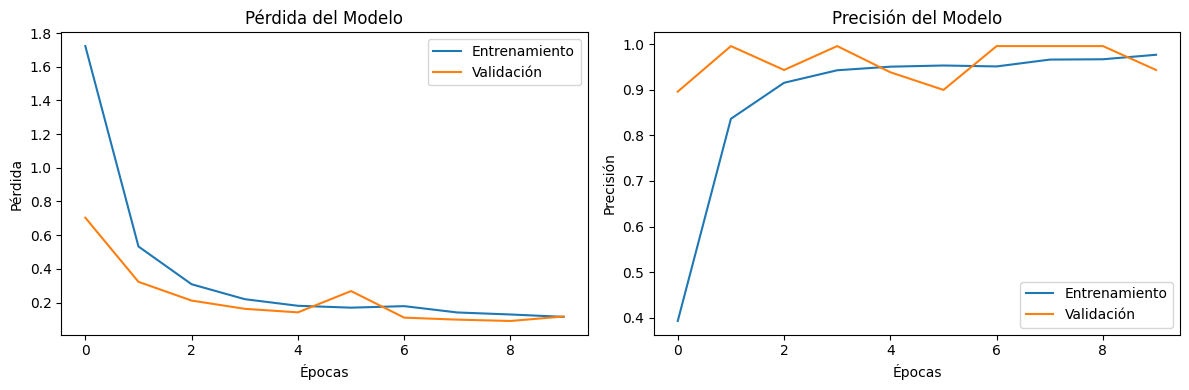

In [ ]:
# Creando el modelo de las redes LSTM (Long Short-Term Memory) en su capa de salida con activación Sigmoide.
modelo = Sequential()
modelo.add(LSTM(units=100, return_sequences=False, input_shape=(window_size, X_train.shape[2])))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=len(np.unique(y_train_encoded)), activation='sigmoid'))

# Compilando el modelo de las redes LSTM (Long Short-Term Memory) con 'accuracy' como métrica.
modelo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento del modelo de las redes LSTM (Long Short-Term Memory) y guardando el historial del entrenamiento.
LSTM_history = modelo.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(LSTM_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
# Extraendo las métricas de entrenamiento y validación.
loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']
accuracy = LSTM_history.history['accuracy']
val_accuracy = LSTM_history.history['val_accuracy']

# Creando gráficos.
plt.figure(figsize=(12, 4))

# Gráficando la pérdida mostrando el cambio de pérdida durante el entrenamiento y la validación.
plt.subplot(1, 2, 1)
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de precisión mostrando el cambio de precisión durante el entrenamiento y la validación.
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Guardado del modelo en formato Keras nativo (.h5)
modelo.save('mejor_modelo.h5')

# Guardado en formato TensorFlow (.tf)
modelo.save('mejor_modelo_tf', save_format='tf')

Epoch 1/10
238/238 - 2s - loss: 0.0974 - accuracy: 0.9779 - val_loss: 0.0379 - val_accuracy: 0.9962 - 2s/epoch - 9ms/step
Epoch 2/10
238/238 - 2s - loss: 0.0519 - accuracy: 0.9934 - val_loss: 0.0356 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 3/10
238/238 - 3s - loss: 0.0460 - accuracy: 0.9949 - val_loss: 0.0332 - val_accuracy: 0.9962 - 3s/epoch - 11ms/step
Epoch 4/10
238/238 - 3s - loss: 0.0467 - accuracy: 0.9946 - val_loss: 0.0325 - val_accuracy: 0.9962 - 3s/epoch - 12ms/step
Epoch 5/10
238/238 - 2s - loss: 0.1474 - accuracy: 0.9641 - val_loss: 0.0347 - val_accuracy: 0.9962 - 2s/epoch - 9ms/step
Epoch 6/10
238/238 - 2s - loss: 0.0474 - accuracy: 0.9948 - val_loss: 0.0331 - val_accuracy: 0.9962 - 2s/epoch - 9ms/step
Epoch 7/10
238/238 - 2s - loss: 0.0452 - accuracy: 0.9950 - val_loss: 0.0310 - val_accuracy: 0.9962 - 2s/epoch - 9ms/step
Epoch 8/10
238/238 - 2s - loss: 0.0649 - accuracy: 0.9893 - val_loss: 0.0410 - val_accuracy: 0.9962 - 2s/epoch - 8ms/step
Epoch 9/10
238/238 - 3

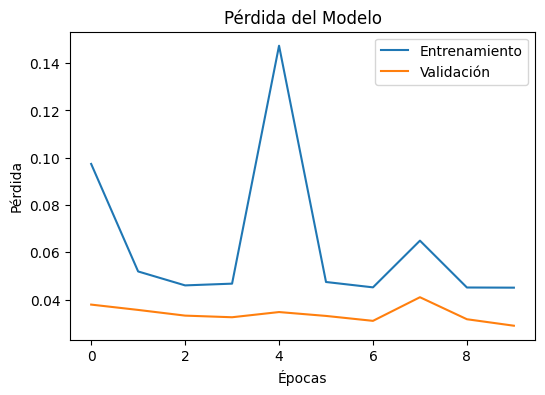

In [ ]:
# Creando el modelo de las redes LSTM (Long Short-Term Memory) en su capa de salida con activación Sigmoide.
LSTM_history = modelo.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(LSTM_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# Extraendo las métricas de entrenamiento y validación del historial.
loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

# Creando un gráfico para mostrar el cambio de pérdida durante el entrenamiento y la validación.
plt.figure(figsize=(6, 4))
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Guardado del modelo en formato Keras nativo (.h5)
modelo.save('mejor_modelo.h5')

# Guardado en formato TensorFlow (.tf)
modelo.save('mejor_modelo_tf', save_format='tf')

**Diseño y Evaluación en diferentes ciudades de los aeropuertos en Norteamérica y Europa Central con la metodología análisis exploratorio de datos - EDA para las variables cinemáticas: Aceleración Máxima (amax), Velocidad Máxima (vmax), Fuerza de Tracción Máxima (FTM) y Potencia de Tracción Máxima (PTM) en Takeoff Cycles.**

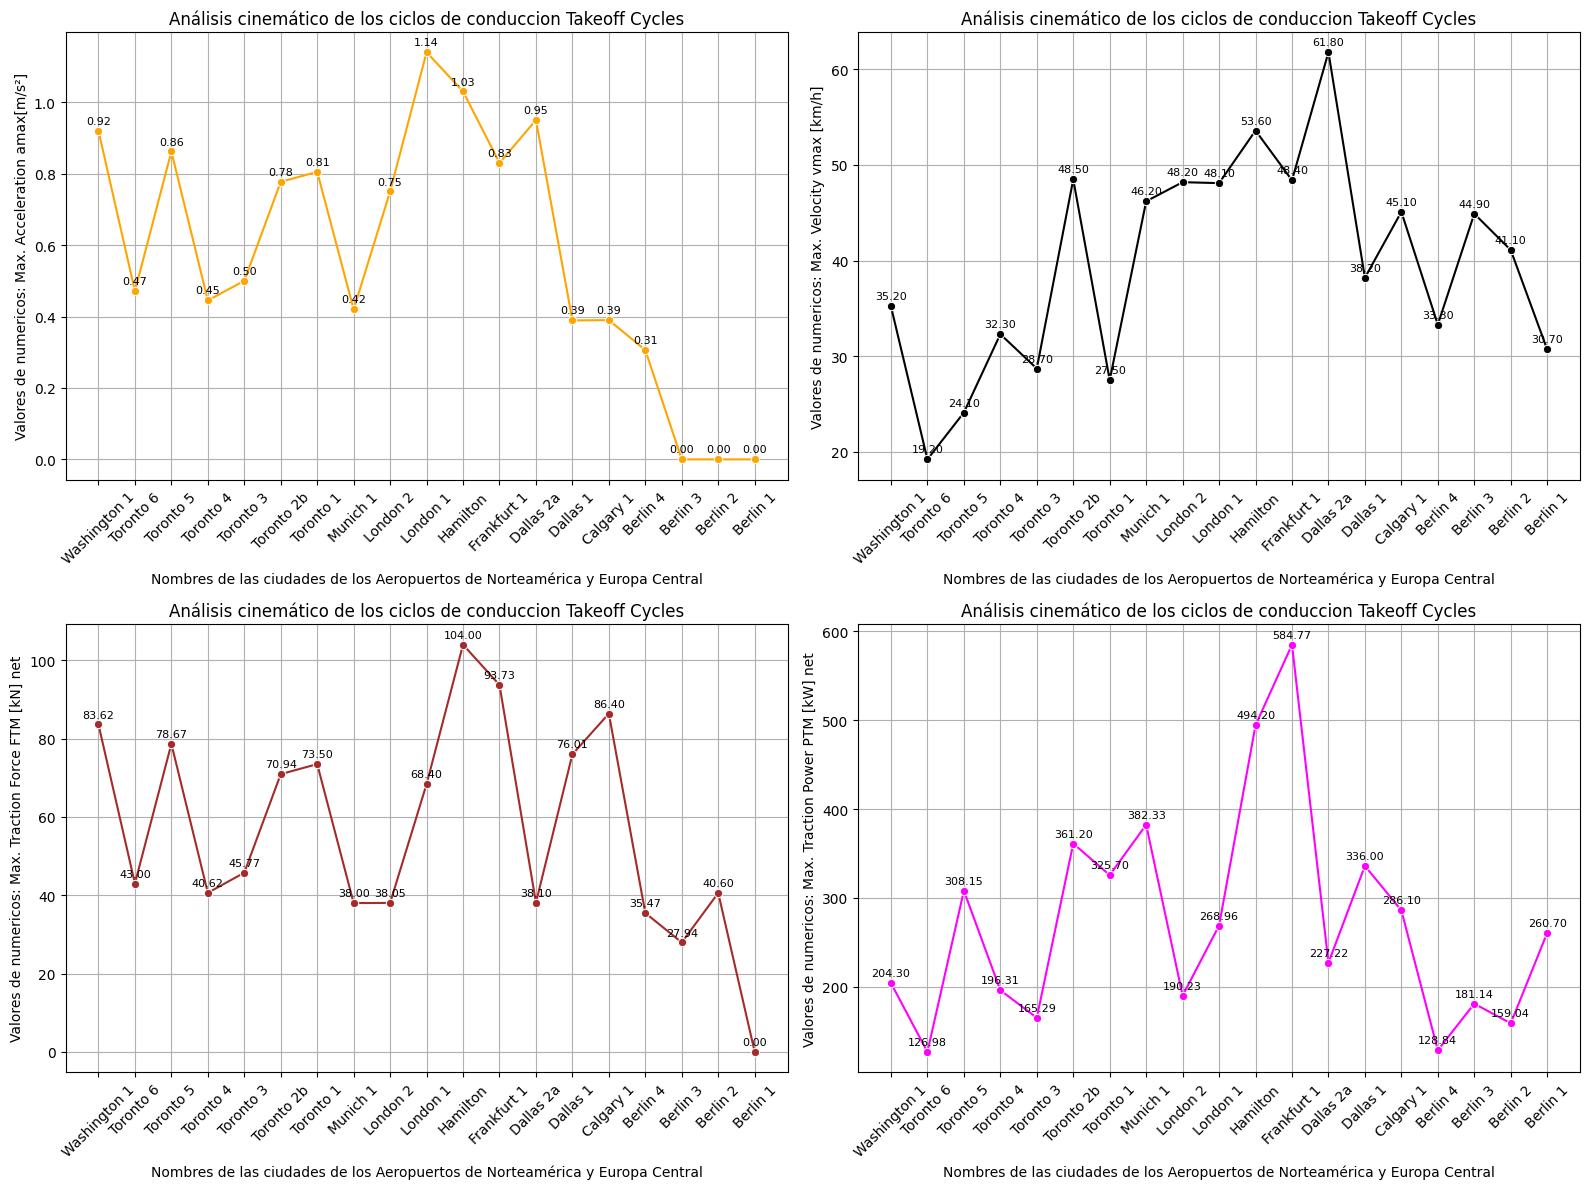

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

# Nombres de las ciudades en 'Takeoff Cycles'.
nombres_ciudades = [
    'Washington 1', 'Toronto 6', 'Toronto 5', 'Toronto 4', 'Toronto 3',
    'Toronto 2b', 'Toronto 1', 'Munich 1', 'London 2', 'London 1', 'Hamilton',
    'Frankfurt 1', 'Dallas 2a', 'Dallas 1', 'Calgary 1', 'Berlin 4', 'Berlin 3',
    'Berlin 2', 'Berlin 1'
]

# Variables a incluir en el Gráfico de series temporales.
variables = ["Max. Acceleration amax[m/s²]", "Max. Velocity vmax [km/h]", "Max. Traction Force FTM [kN] net", "Max. Traction Power PTM [kW] net"]

data = {
    "Max. Acceleration amax[m/s²]": [0.92, 0.471, 0.862, 0.445, 0.5, 0.777, 0.805, 0.42, 0.75, 1.14, 1.03, 0.83, 0.95, 0.389, 0.39, 0.306, 0.0, 0.0, 0.0],
    "Max. Velocity vmax [km/h]": [35.2, 19.2, 24.1, 32.3, 28.7, 48.5, 27.5, 46.2, 48.2, 48.102, 53.602, 48.4, 61.8, 38.2, 45.1, 33.3, 44.9, 41.102, 30.703],
    "Max. Traction Force FTM [kN] net": [83.62, 43, 78.67, 40.62, 45.77, 70.94, 73.5, 38, 38.05, 68.4, 104, 93.73, 38.1, 76.01, 86.4, 35.47, 27.94, 40.6, 0.0],
    "Max. Traction Power PTM [kW] net": [204.3, 126.98, 308.15, 196.31, 165.29, 361.2, 325.7, 382.33, 190.23, 268.96, 494.2, 584.77, 227.22, 336, 286.1, 128.84, 181.14, 159.04, 260.7]
}

df = pd.DataFrame(data)

plt.figure(figsize=(16, 12))

# Configurando un contador para el subplot.
count = 1

# Definiendo los colores para los Gráficos de series temporales.
colores = ['orange', 'black', 'brown', 'magenta']

# Creando gráficos de series temporales para cada una de las variables.
for variable, color in zip(variables, colores):
    plt.subplot(2, 2, count)
    sns.lineplot(data=df, x=nombres_ciudades, y=df[variable], marker='o', color=color)
    plt.grid(True)

    # Agregando etiquetas con valores numéricos en cada punto.
    for i, valor in enumerate(df[variable]):
        plt.annotate(f'{valor:.2f}', (i, valor), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    plt.title(f'Análisis cinemático de los ciclos de conduccion Takeoff Cycles')
    plt.xlabel('Nombres de las ciudades de los Aeropuertos de Norteamérica y Europa Central')
    plt.ylabel(f'Valores de numericos: {variable}')
    plt.xticks(rotation=45)
    count += 1

plt.tight_layout()
plt.show()

# Estadísticas descriptivas para cada una de las variables del conjunto de datos (dataset).
for variable in variables:
    descriptive_stats = df[variable].describe()

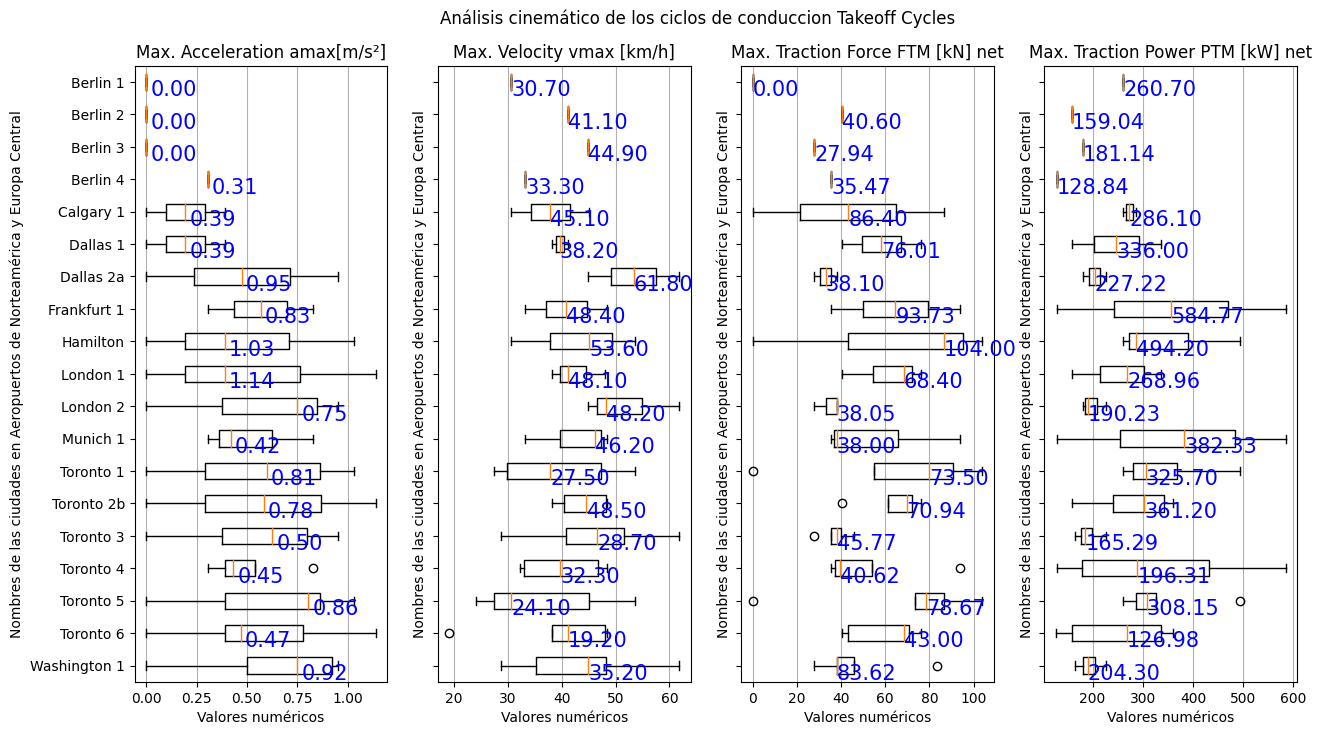

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de las ciudades en 'Takeoff Cycles'.
nombres_ciudades = [
    'Washington 1', 'Toronto 6', 'Toronto 5', 'Toronto 4', 'Toronto 3',
    'Toronto 2b', 'Toronto 1', 'Munich 1', 'London 2', 'London 1', 'Hamilton',
    'Frankfurt 1', 'Dallas 2a', 'Dallas 1', 'Calgary 1', 'Berlin 4', 'Berlin 3',
    'Berlin 2', 'Berlin 1'
]

# Variables a incluir en el Gráfico de Caja.
variables = ["Max. Acceleration amax[m/s²]", "Max. Velocity vmax [km/h]", "Max. Traction Force FTM [kN] net", "Max. Traction Power PTM [kW] net"]

data = {
    "Max. Acceleration amax[m/s²]": [0.92, 0.471, 0.862, 0.445, 0.5, 0.777, 0.805, 0.42, 0.75, 1.14, 1.03, 0.83, 0.95, 0.389, 0.39, 0.306, 0.0, 0.0, 0.0],
    "Max. Velocity vmax [km/h]": [35.2, 19.2, 24.1, 32.3, 28.7, 48.5, 27.5, 46.2, 48.2, 48.102, 53.602, 48.4, 61.8, 38.2, 45.1, 33.3, 44.9, 41.102, 30.703],
    "Max. Traction Force FTM [kN] net": [83.62, 43, 78.67, 40.62, 45.77, 70.94, 73.5, 38, 38.05, 68.4, 104, 93.73, 38.1, 76.01, 86.4, 35.47, 27.94, 40.6, 0.0],
    "Max. Traction Power PTM [kW] net": [204.3, 126.98, 308.15, 196.31, 165.29, 361.2, 325.7, 382.33, 190.23, 268.96, 494.2, 584.77, 227.22, 336, 286.1, 128.84, 181.14, 159.04, 260.7]
}

# Configurando los colores y el tamaño para las etiquetas numericas del conjunto de datos (dataset).
etiqueta_color = 'blue'
etiqueta_tamano = 15

# Creando subgráficos para cada una de las variables del conjunto de datos (dataset).
fig, axs = plt.subplots(1, len(variables), figsize=(15, 8), sharey=True)

for i, variable in enumerate(variables):
    data_to_plot = [data[variable][i::len(variables)] for i in range(len(nombres_ciudades))]
    box = axs[i].boxplot(data_to_plot, vert=False)

    # Agregando etiquetas de los valores numéricos del conjunto de datos (dataset) en cada punto con color y tamaño personalizado.
    for j, ciudad in enumerate(nombres_ciudades):
        axs[i].text(box['medians'][j].get_xdata()[0] + 0.02, box['medians'][j].get_ydata()[0], f'{data[variable][j]:.2f}', fontsize=etiqueta_tamano, va='center', color=etiqueta_color)

    axs[i].set_title(f'{variable}')

axs[0].set_yticks(np.arange(1, len(nombres_ciudades) + 1))
axs[0].set_yticklabels(nombres_ciudades)

# Añadiendo personalizaciones adicionales del conjunto de datos (dataset).
for ax in axs:
    ax.set_xlabel('Valores numéricos')
    ax.set_ylabel('Nombres de las ciudades en Aeropuertos de Norteamérica y Europa Central')
    ax.grid(axis='x')

plt.suptitle('Análisis cinemático de los ciclos de conduccion Takeoff Cycles', y=0.95)
plt.show()